# Optimal Potfoliop selection
selecting the best portfolio (asset distribution), out of the set of all portfolios being considered, according to some objective. The objective typically maximizes factors such as expected return, and minimizes costs like financial risk. Factors being considered may range from tangible (such as assets, liabilities, earnings or other fundamentals) to intangible (such as selective divestment).

Modern portfolio theory was introduced in a 1952 doctoral thesis by Harry Markowitz. It assumes that an investor wants to maximize a portfolio's expected return contingent on any given amount of risk. For portfolios that meet this criterion, known as efficient portfolios, achieving a higher expected return requires taking on more risk, so investors are faced with a trade-off between risk and expected return. This risk-expected return relationship of efficient portfolios is graphically represented by a curve known as the __efficient frontier__. All efficient portfolios, each represented by a point on the efficient frontier, are well-diversified. While ignoring higher moments can lead to significant over-investment in risky securities, especially when volatility is high, the optimization of portfolios when return distributions are non-Gaussian is mathematically challenging.



# Data

## Sets
* $\Omega$: set of stocks


## Parameters
* $\lambda_i: $ Price of stock $i$ at present time
* $\hat{\lambda_i}:$ Expected price of stock $i$ at future
* $S \in M^{N x N}$: Covariance matrix

## Constants
* $N = |\Omega|$ : no. stocks
* $A$: Ammount of money to invest


## Variables

* $X \in M^{1x N}$: decision vector related to the Participation of each stock $i \in \Omega$


# Model
## Objective function
Objective is to minimize risk (profit volatility, i.e variance).  This is modeled using the
covariance matrix, which measures the historical correlation between stocks.



$$
min_x \hspace{0.2cm} \{z = Var \left[ \sum_i x_i \lambda_i \right] = \sum_i \sum_j s_{i,j} x_i x_j = X S X^T \}
$$

where $S \in \mathcal{R}^{n\cdot n} $ is the covariance matrix of the $\Lambda = [\lambda_1, \ldots, \lambda_n] $ price vector and $X \in \mathcal{R^n}$ is the decision vector 

## Constraints

### Constraint 1
Ammount of money to invest
$$
\Lambda X^T = \sum_i x_i  \lambda_i \leq A
$$



# Pyomo Model

In [12]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
import numpy as np
np.random.seed(0)
path_cplex = '/Applications/CPLEX_Studio_Community201/cplex/bin/x86-64_osx/cplex'
path_gurobi=  '/usr/local/bin/gurobi.sh'

## Model Data

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
def plot_stocks(data):
    fig = plt.figure(figsize=(10, 4), dpi=150, facecolor='w', edgecolor='w')
    fontsize=8
    for i in range(data.shape[1]):
        stock = data.columns[i]
        ax = fig.add_subplot(4, 2, i+1)
        ax.plot(data.index,
                 data[stock],
                 linewidth=1,
                 linestyle='solid',
                 color='k',
                 label=stock)
        ax.set_ylabel(stock)
        #ax.set_xlabel('Time')
        ax.grid(True)
        #plt.legend()
        ax.tick_params(axis='both', labelsize=fontsize)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.show()
    

### Real data

In [39]:
data = pd.read_csv('data/stocks_data_procesed.csv')
data.set_index(['Date'], inplace=True, drop=True)
stocks = data.columns
stocks = data.columns.to_list()
# normalize stocks data
for stock in stocks:
    data[stock] = (data[stock] - data[stock].min()) / (data[stock].max() - data[stock].min())
# Standard deviation per stock
stock_volatility = data.std().to_list()
stock_volatility = {stocks[i]:stock_volatility[i] for i in range(len(stocks))}
# Expected value per stock
stock_return = data.mean().to_list()
stock_return = {stocks[i]:stock_return[i] for i in range(len(stocks))}
# Convariance matrix
sigma = data.cov()
S = {(i,j):sigma.loc[i,j] for i in stocks for j in stocks if i!=j}

## Dummy data

In [42]:
# Import (normalized) historical return data using pandas
data = pd.read_csv('data/portfolio.csv', index_col=0)
capital = 1
stocks = data.columns.to_list()
# Standard deviation per stock
stock_volatility = data.std().to_list()
stock_volatility = {stocks[i]:stock_volatility[i] for i in range(len(stocks))}
# Expected value per stock
stock_return = data.mean().to_list()
stock_return = {stocks[i]:stock_return[i] for i in range(len(stocks))}
# Covaraince matrix stocks
sigma = data.cov()
S = {(i,j):sigma.loc[i,j] for i in stocks for j in stocks}

In [97]:
#
# --- DEFINE MODEL ---
#

# model
model = pyo.ConcreteModel()
# Indexes
#model.i = pyo.RangeSet(1, N)
model.stocks  = pyo.Set(initialize=stocks)
# Variables
model.x = pyo.Var(model.stocks, domain=pyo.Reals, initialize=0)  # PositiveReals PositiveIntegers
# Parameters
# Stock volatility
model.stock_volatity = pyo.Param(model.stocks, initialize=stock_volatility, within=pyo.Any)
# expected stock value 
model.stock_return = pyo.Param(model.stocks, initialize=stock_return, within=pyo.Any)
# covariance
model.cov = pyo.Param(model.stocks, model.stocks, initialize=S, within=pyo.Any)
# min risk return
model.minrisk_return = pyo.Param(initialize=0, mutable=True, within=pyo.Any)

# Expresion portfolio return
def portfolio_return(model):
    return sum(model.stock_return[i]*model.x[i] for i in model.stocks)
model.portfolio_return = pyo.Expression(rule=portfolio_return)

# Expresion portfolio risk 
def portfolio_risk(model):
    return sum(model.cov[i, j]*model.x[i]*model.x[j] for i in stocks for j in model.stocks)
model.portfolio_risk = pyo.Expression(rule=portfolio_risk)

# Constraint capital invested
def captial_constraint(model):
    return model.portfolio_return == capital 
model.c_captial_constraint = pyo.Constraint(rule=captial_constraint)


# Constraint porfoli return
def minrisk_return(model):
    return model.portfolio_return == model.minrisk_return 
model.c_minrisk_return = pyo.Constraint(rule=minrisk_return)


# Objective
def objective_rule(model):
    return model.portfolio_risk 
model.OF = pyo.Objective(rule=objective_rule, sense=pyo.minimize, doc='minimize risk')


model.c_minrisk_return.deactivate()

In [101]:


#
# --- SOLVE MODEL ---
#

opt = SolverFactory("gurobi", solver_io="python")  # glpk
#opt = SolverFactory("cplex", solver_io="python", executable=path_cplex)  # glpk
#opt = SolverFactory("glpk")  # glpk
#opt = SolverFactory("ipopt")  # ipopt
results = opt.solve(model, tee=True)  # tee=True for details

# Check the solution
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('--- Termination Condition ---')
    print('    {}'.format(results.solver.termination_condition))
    #print('\n')
    #print('--- Results ---')
    #print('Feasible solution')
    #model.OF.pprint()

    # Display minimum risk portfolio
    print('\n')
    print(' --- Minimum Risk Portfolio --- \n')
    for stock in model.stocks:
        print('    {}: {}'.format(stock, pyo.value(model.x[stock])))
    print('\n')
    minrisk_volatility = np.sqrt(model.portfolio_risk())
    minrisk_return = model.portfolio_return()
    print('   Volatility: {}'.format(minrisk_volatility))
    print('   Expected return: {}'.format(minrisk_return))



    model.c_minrisk_return.activate()
    model.c_captial_constraint.deactivate()
    model.minrisk_return = minrisk_return
    
     # Create a set of constraints
    #model.constraints = pyo.ConstraintList()
    #model.constraints.add(model.portfolio_return ==  minrisk_return)
    
    # Constraint Target
    #def target_constraint(model):
    #    return model.portfolio_return ==  minrisk_return
    
    #model.target_constraint = pyo.Constraint(rule=target_constraint)
    
    #
    # --- SOLVE MODEL AGAIN ---
    #

    # Solve for efficient frontier by varying target return
    frontier = pd.Series(dtype=np.float64)
    for r in np.linspace(min(stock_return.values()), max(stock_return.values()), 100):
        
        model.c_minrisk_return.rhs = r
        results = opt.solve(model)  # tee=True for details
        #print('Risk:', model.portfolio_risk())
        #print('Stock Return:',r)
        frontier.loc[np.sqrt(model.portfolio_risk())] = r

        

    #print('--- Problem Results ---')
    #print(results.Problem())
    #print('--- Solver Results ---')
    #print('Execution time: {}'.format(results.Solver().Time))
elif results.solver.termination_condition == TerminationCondition.infeasible:
    print('termination condition:', results.solver.termination_condition)
    print('(!) Infeasible solution')
else:
    #
    # Something else is wrong
    print('--- Termination Condition ---')
    print('  (!) {}'.format(results.solver.termination_condition))
    print('\n')
    model.pprint()
    #print('Status:', results.solver.status)



Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to /var/folders/9k/04pt01hs1ng95lppnvj97vw40000gn/T/tmpav0c8ptp.log
   Prev:   Default: 
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0xe9884101
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-04, 1e-02]
  Objective range  [0e+00, 0e+00]
  QObjective range [3e-05, 7e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 10 columns, 10 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 4.500e+01
 Factor NZ  : 5.500e+01
 Factor Ops : 3.850e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter  

In [90]:

# =================
# PLOTS
# ================

def plot_portfolio(stock_volatility, minrisk_volatility, minrisk_return, stock_return, frontier):
    # Plot volatility versus expected return for individual stocks
    fig = plt.figure(figsize=(12, 6), dpi=100, facecolor='w', edgecolor='w')
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(x=stock_volatility,
               y=stock_return,
               color='Blue',
               label='Individual Stocks')
    for i, stock in enumerate(stocks):
        ax.annotate(stock, (stock_volatility[i], stock_return[i]))

    # Plot volatility versus expected return for minimum risk portfolio
    ax.scatter(x=minrisk_volatility,
               y=minrisk_return,
               color='DarkGreen',
               label='Minimum Risk Point')
    ax.annotate('Minimum\nRisk\nPortfolio',
                (minrisk_volatility, minrisk_return),
                horizontalalignment='right')

    # Plot efficient frontier
    ax.plot(frontier,
            color='DarkGreen',
            label='Efficient Frontier')

    ax.hlines(y=np.zeros(len(np.arange(0, max(stock_volatility), 0.005))),
              xmin=0,
              xmax=max(stock_volatility),
              color='gray',
              linestyle='dashed',
              linewidth=1)
    # Format and display the final plot
    ax.axis([0.005, 0.06, -0.02, 0.025])
    ax.set_xlabel('Volatility (standard deviation)')
    ax.set_ylabel('Expected Return')
    ax.legend()
    ax.grid()
    plt.savefig('../figures/portfolio.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    # print("Plotted efficient frontier to 'portfolio.png'")


def plot_stocks_timeseries(data):
    fig = plt.figure(figsize=(16, 6), dpi=120, facecolor='w', edgecolor='w')

    for i in np.arange(0, data.shape[1]):
        ax = fig.add_subplot(5, 2, i + 1)
        ax.plot(data[data.columns[i]],
                label=data.columns[i],
                linestyle='dashed', color='k', linewidth=1)

        # ax.axis([0.005, 0.06, -0.02, 0.025])
        ax.set_xlabel('Time')
        ax.set_ylabel('Stock Value')
        # ax.set_title(data.columns[i])
        ax.legend()
        ax.grid()
    plt.subplots_adjust(wspace=0.3, hspace=1.2)
    plt.savefig('../figures/portfolio_stocks.png', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()



In [91]:
stock_volatility_ = [stock_volatility[key] for key in stock_volatility.keys()]
stock_return_ =  [stock_return[key] for key in stock_return.keys()]

ValueError: x and y must be the same size

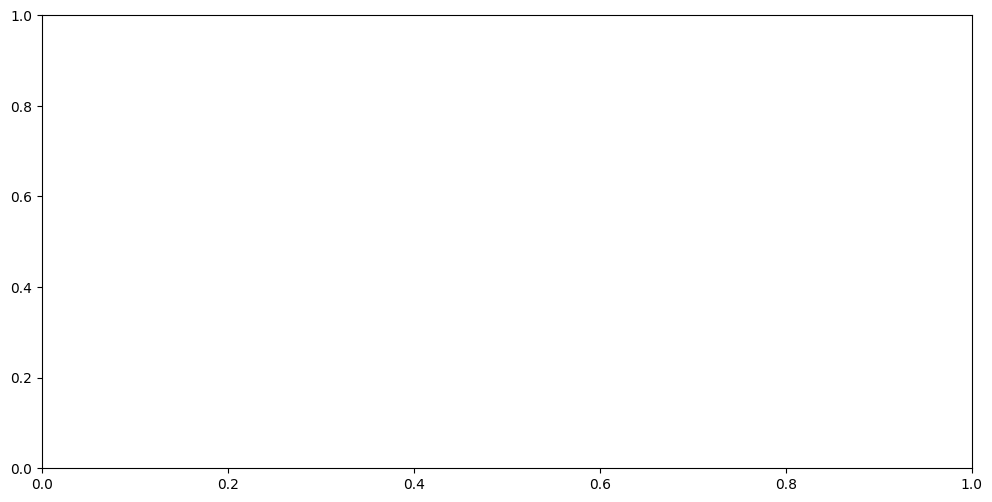

In [92]:
plot_portfolio(stock_volatility_,
               minrisk_volatility,
               minrisk_return,
              stock_return,
              frontier)

# References

[1]. [Formulación y resolucuión de Modelos de Programación Matemática en Ingeniería y Ciencia](http://www.dia.fi.upm.es/~jafernan/teaching/operational-research/LibroCompleto.pdf)